# Importing libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import joblib

# Data Preprocessing


In [2]:
# Load datasets
purchase_df = pd.read_csv("purchase_ds.csv")
rewards_df = pd.read_csv("rewards_ds.csv")

In [3]:
purchase_df.isnull().sum()

Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Age                      0
Gender                   0
Product Name             0
dtype: int64

In [4]:
print(purchase_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Customer ID            250000 non-null  int64 
 1   Purchase Date          250000 non-null  object
 2   Product Category       250000 non-null  object
 3   Product Price          250000 non-null  int64 
 4   Quantity               250000 non-null  int64 
 5   Total Purchase Amount  250000 non-null  int64 
 6   Age                    250000 non-null  int64 
 7   Gender                 250000 non-null  object
 8   Product Name           250000 non-null  object
dtypes: int64(5), object(4)
memory usage: 17.2+ MB
None


In [5]:
purchase_df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Age,Gender,Product Name
0,46251,08-09-2020,Electronics,12,3,740,37,Male,Wearable device
1,46251,05-03-2022,Home,468,4,2739,37,Male,Bathroom accessories
2,46251,23-05-2022,Home,288,2,3196,37,Male,Lighting fixtures
3,46251,12-11-2020,Attire,196,1,3509,37,Male,Tops
4,13593,27-11-2020,Home,449,1,3452,49,Female,Kitchen appliances


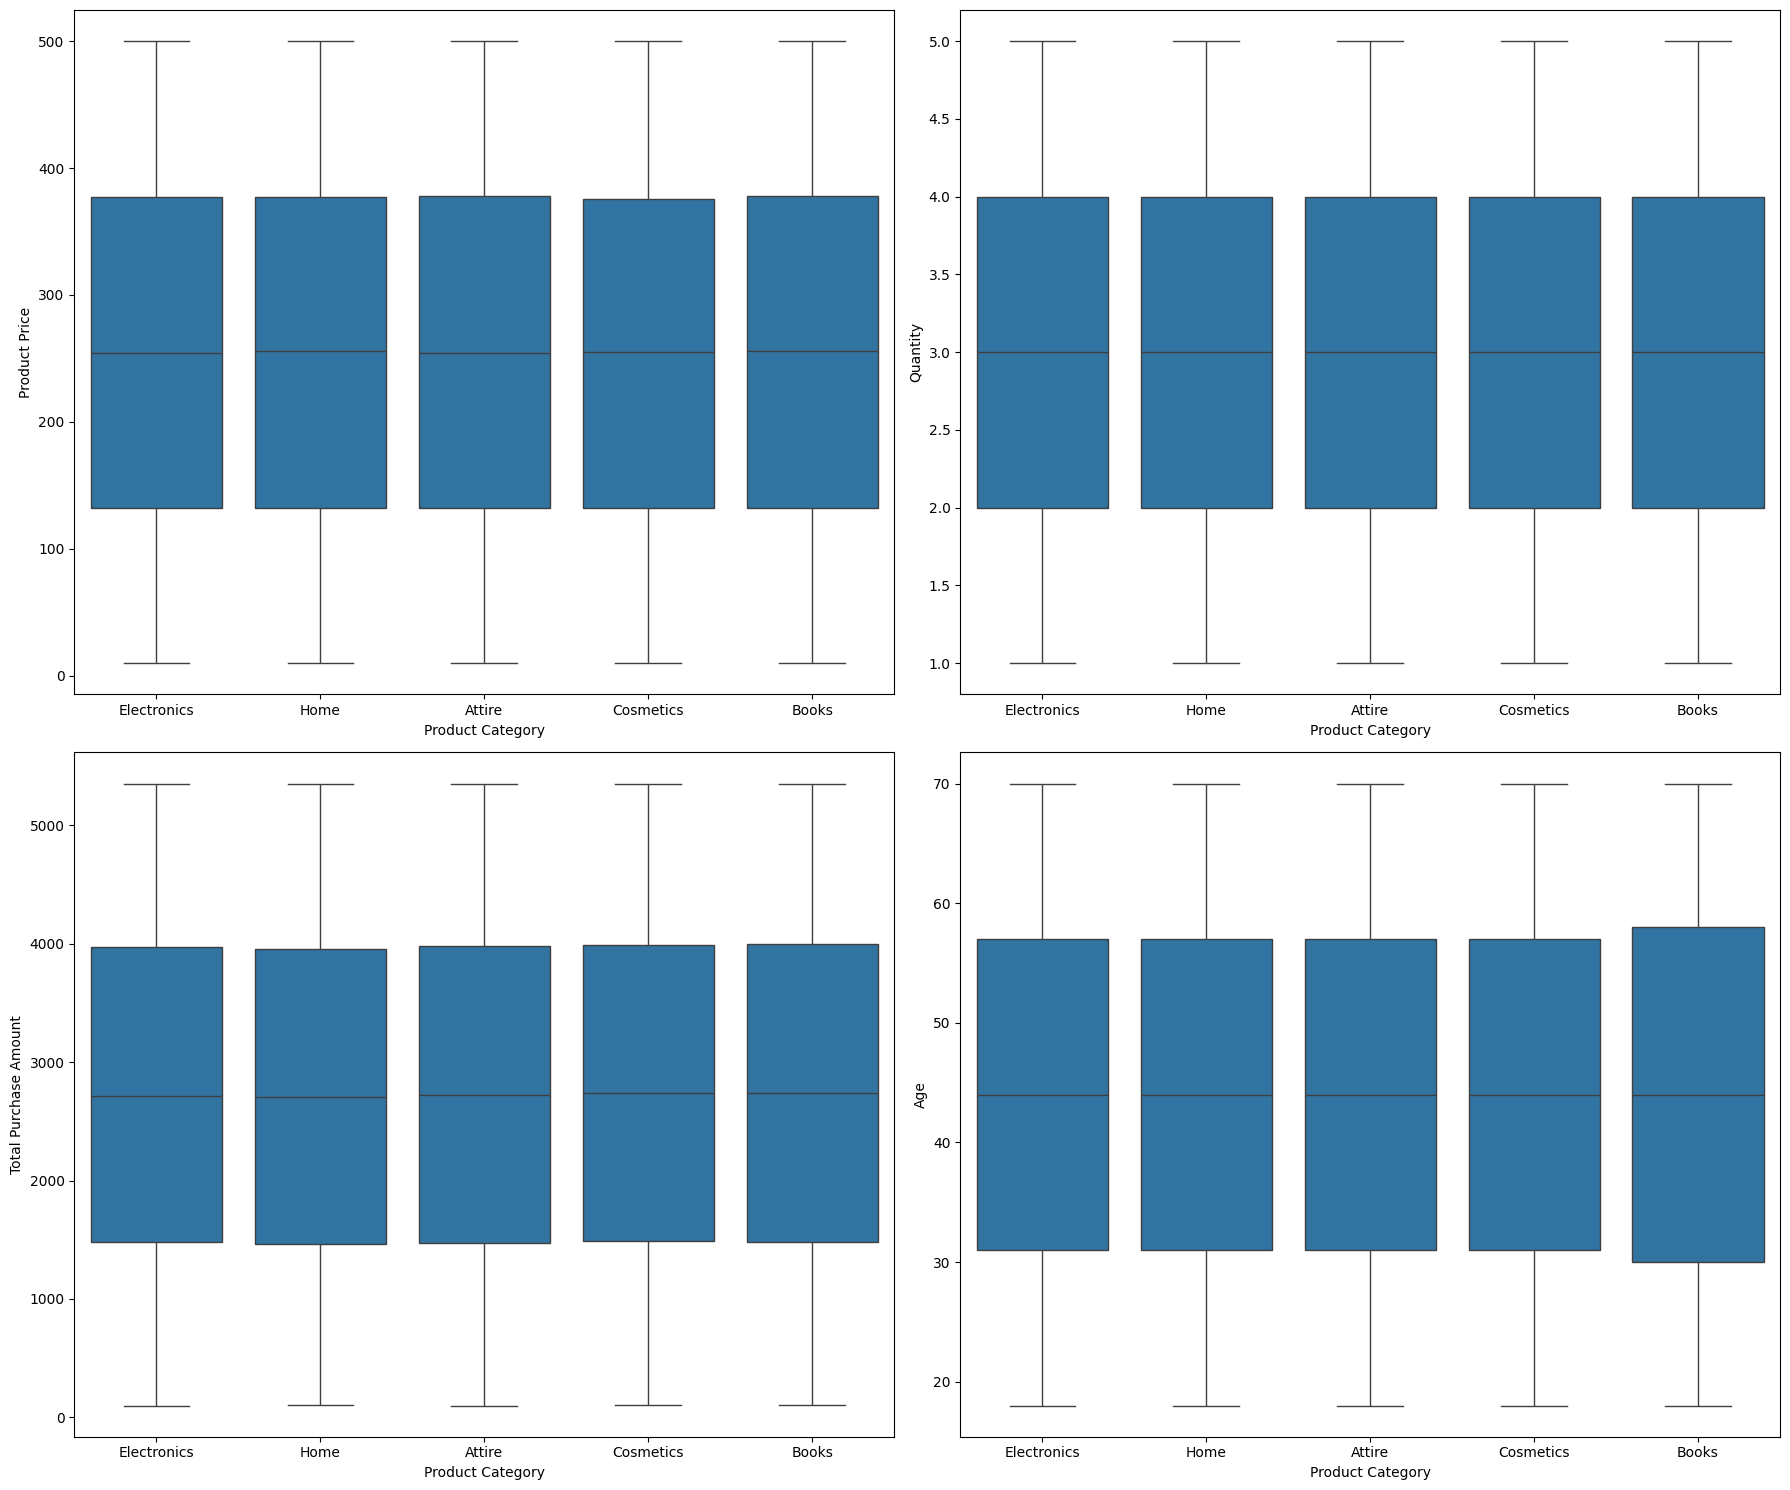

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))

sns.boxplot(ax=axes[0, 0], data=purchase_df, x='Product Category', y='Product Price')
sns.boxplot(ax=axes[0, 1], data=purchase_df, x='Product Category', y='Quantity')
sns.boxplot(ax=axes[1, 0], data=purchase_df, x='Product Category', y='Total Purchase Amount')
sns.boxplot(ax=axes[1, 1], data=purchase_df, x='Product Category', y='Age')

plt.tight_layout()

plt.show()

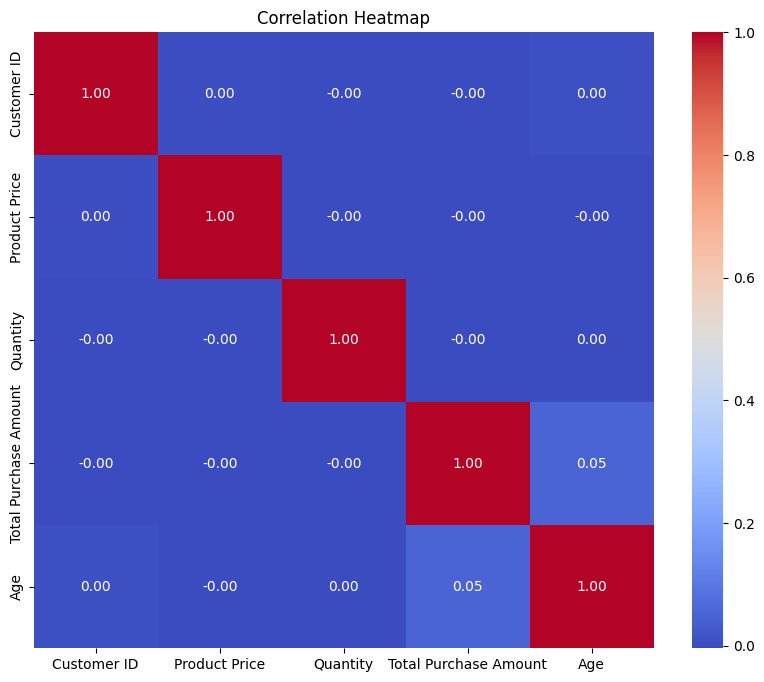

In [7]:
numerical_cols = purchase_df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Heatmap')

plt.show()

In [8]:
rewards_df.isnull().sum()

Reward ID             0
Reward Name           0
Reward Description    0
Start Date            0
Expiration Date       0
Category              0
dtype: int64

In [9]:
print(rewards_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Reward ID           23 non-null     object
 1   Reward Name         23 non-null     object
 2   Reward Description  23 non-null     object
 3   Start Date          23 non-null     object
 4   Expiration Date     23 non-null     object
 5   Category            23 non-null     object
dtypes: object(6)
memory usage: 1.2+ KB
None


In [10]:
rewards_df.head()

,Reward ID,Reward Name,Reward Description,Start Date,Expiration Date,Category
0,AMEX001,20% off Ray-Ban Sunglasses,Treat yourself to a new pair of stylish sungla...,2024-05-01,2024-06-30,Attire
1,AMEX002,$50 Statement Credit on New Samsung Galaxy Phone,Upgrade your phone and get a $50 statement cre...,2024-04-15,2024-05-31,Electronics
2,AMEX003,10% off All KitchenAid Appliances,Spruce up your kitchen with 10% off all Kitche...,2024-04-20,2024-05-20,Home
3,AMEX004,Free Audiobook with Audible Trial,Dive into a new world with a free audiobook wh...,2024-04-01,2024-06-30,Books
4,AMEX005,15% off Fenty Beauty Products,Enhance your natural beauty with 15% off all F...,2024-05-10,2024-06-15,Cosmetics


#Model Training


In [11]:
# Create a sparse matrix where rows represent customers and columns represent products
customer_product_matrix = purchase_df.pivot_table(index='Customer ID', columns='Product Name', values='Quantity', fill_value=0)

# Initialize and fit Nearest Neighbors model
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(customer_product_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

# Recommendation Generation

In [12]:
def get_recommendations(customer_id, num_recommendations=3):
    """
    Generate personalized product recommendations for a given customer.

    Parameters:
    - customer_id (int): The ID of the customer for whom recommendations are generated.
    - num_recommendations (int): The number of recommendations to generate.

    Returns:
    - recommended_products (list): A list of recommended product names.
    """
    # Find k nearest neighbors of the customer
    distances, indices = nn_model.kneighbors(customer_product_matrix.loc[[customer_id]], n_neighbors=num_recommendations+1)
    similar_customers = customer_product_matrix.iloc[indices[0][1:]]  # Exclude the customer itself

    # Aggregate products purchased by similar customers
    aggregated_products = similar_customers.sum(axis=0)

    # Sort products by total quantity purchased by similar customers
    recommended_products = aggregated_products.sort_values(ascending=False).index[:num_recommendations]

    return recommended_products.tolist()

In [13]:
def format_rewards(recommended_products, num_offers=3):
    """
    Format rewards based on recommended products.

    Parameters:
    - recommended_products (list): A list of recommended product names.
    - num_offers (int): The number of reward offers to return if no matching rewards are found.

    Returns:
    - DataFrame: A DataFrame containing formatted reward offers.
    """
    recommended_categories = purchase_df[purchase_df['Product Name'].isin(recommended_products)]['Product Category'].unique()
    matching_rewards = rewards_df[rewards_df['Category'].isin(recommended_categories)]

    if not matching_rewards.empty:
        return matching_rewards[['Reward ID', 'Reward Name', 'Reward Description', 'Start Date', 'Expiration Date', 'Category']].head(3)
    else:
        random_offers = rewards_df.sample(n=num_offers)
        return random_offers[['Reward ID', 'Reward Name', 'Reward Description', 'Start Date', 'Expiration Date', 'Category']].head(3)

# Testing with Input

In [14]:
# Example usage:
customer_id = 46251
recommended_products = get_recommendations(customer_id)
recommended_rewards = format_rewards(recommended_products)
print(recommended_rewards)

  Reward ID                                       Reward Name  \
1   AMEX002  $50 Statement Credit on New Samsung Galaxy Phone   
2   AMEX003                 10% off All KitchenAid Appliances   
5   AMEX007             20% off Select Home Decor at West Elm   

                                  Reward Description  Start Date  \
1  Upgrade your phone and get a $50 statement cre...  2024-04-15   
2  Spruce up your kitchen with 10% off all Kitche...  2024-04-20   
5  Refresh your home with 20% off select home dec...  2024-04-25   

  Expiration Date     Category  
1      2024-05-31  Electronics  
2      2024-05-20         Home  
5      2024-05-25         Home  


# Creating a Pipeline

In [15]:
pipeline = Pipeline([
    ('model_training', nn_model),
    ('recommendation_generation', get_recommendations),
    ('recommended_rewards', format_rewards)
])

# Joblib

In [16]:
joblib.dump(pipeline, 'personalized_recommendation_pipeline.joblib')

['personalized_recommendation_pipeline.joblib']

In [17]:
# Example usage with loaded pipeline:
loaded_pipeline = joblib.load('personalized_recommendation_pipeline.joblib')
customer_id = 46251
recommended_products = loaded_pipeline.named_steps['recommendation_generation'](customer_id)
print("Recommended Products:", recommended_products)
recommended_rewards = loaded_pipeline.named_steps['recommended_rewards'](recommended_products)
print("Recommended Rewards:")
print(recommended_rewards)

Recommended Products: ['Bathroom accessories', 'Wearable device', 'Lighting fixtures']
Recommended Rewards:
  Reward ID                                       Reward Name  \
1   AMEX002  $50 Statement Credit on New Samsung Galaxy Phone   
2   AMEX003                 10% off All KitchenAid Appliances   
5   AMEX007             20% off Select Home Decor at West Elm   

                                  Reward Description  Start Date  \
1  Upgrade your phone and get a $50 statement cre...  2024-04-15   
2  Spruce up your kitchen with 10% off all Kitche...  2024-04-20   
5  Refresh your home with 20% off select home dec...  2024-04-25   

  Expiration Date     Category  
1      2024-05-31  Electronics  
2      2024-05-20         Home  
5      2024-05-25         Home  
